### We have different dataframes: 

1. **Spotify_600**: all tracks and features associated to tracks, from this dataframe we delete the non-music songs
2. **artists_600**: all artists and a small number of features related to the artists
3. **feat_track_600**: all songs with more than one artist, since 1999 (passed to create nodes_600)
4. **nodes_600**: edge lists from source to target, including number of features and songs in which they collaborated
5. **artists_600_features**: artist features, popularity and song features for all songs
6. **genres**: all genres with the number of artists having that genre

In [145]:
import pandas as pd
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as ntx
import re
import random
from sklearn.manifold import TSNE

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
# ref doc https://github.com/eliorc/node2ve and https://towardsdatascience.com/node2vec-embeddings-for-graph-data-32a866340fef
from node2vec import Node2Vec 
from sklearn.model_selection import train_test_split
from music_utils import *
from tqdm.auto import tqdm  # import tqdm for progress bar
tqdm.pandas()
from gensim.models import Word2Vec


from sklearn import preprocessing
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_sample_weight



In [2]:
local = True
if local:
    DATA_PATH = '../data/'
else:
    DATA_PATH = './data/'

In [3]:
def graph_largest_cc(nodes_df, plot_graph=False, write_graphml=None):   
    edge_list = [tuple(l[:2]) for l in nodes_df.values.tolist()]
    G = ntx.from_edgelist(edge_list)
    largest_cc = G.subgraph(max(ntx.connected_components(G), key=len))
    print(f'The largest connected component has {len(largest_cc.nodes)} nodes.')
    print(f'The largest connected component has {len(largest_cc.edges)} edges.')

    if plot_graph:
        fig, ax = plt.subplots(figsize=(15, 15))
        ntx.draw_networkx(largest_cc, with_labels=False, node_size = 20, ax = ax)
        plt.show()
    
    if write_graphml != None:
        ntx.write_graphml_lxml(G, write_graphml+'.graphml')
    return G, largest_cc

Ran this once on the CSV's from the kaggle website, is now saved locally in pickle files

In [4]:
spotify_600, artists_600 = read_spotify_600(DATA_PATH=DATA_PATH, read=True)

We filter out the non-music tracks, then we create the edge lists and the features for artists. 

In [5]:
# Filter out non-music
n_non_music = sum(spotify_600["speechiness"] > 0.7)
print(f"We are deleting {n_non_music} songs from the dataframe")
spotify_600 = spotify_600[spotify_600["speechiness"] < 0.7]

We are deleting 22100 songs from the dataframe


In [6]:
#Nodes creation
feat_track_600 = spotify_600[(spotify_600.num_artists > 1)&(spotify_600.release_date.dt.year > 1999)].copy()
nodes_600 = nodes_featuring(feat_track_600, DATA_PATH=DATA_PATH, read=False, path='edge_list_600k_over1999.pkl')

In [80]:
def artists_features_creation(artists_600, spotify_600, DATA_PATH, read=True,
                              pkl_features_artist_path='features_artists_600k.pkl',
                              ):
    """
    :param artists_600: the dataframe with artists
    :param spotify_600: the dataframe with tracks
    :param DATA_PATH: where to save or read the data
    :param read: has data already been saved to pickle? then just read
    :param pkl_features_artist_path: where to save or read artists features data

    :return: dataframe with for each artist the features related to tracks in which they were involved
    """

    if read:
        artists_600_features = pd.read_pickle(DATA_PATH + pkl_features_artist_path)

    else:
        # we select all the artists that are in the spotify tracks
        artists_600_features = artists_600[artists_600.artist_id.isin(spotify_600.id_artists.explode().unique())].copy()
        # features: number of genres
        artists_600_features['num_genres'] = artists_600_features.genres.apply(lambda x: len(x))
        # set artist_id as index
        artists_600_features = artists_600_features.set_index('artist_id')
        # the features we want from spotify track
        feature_cols = ['track_popularity', 'duration_ms', 'explicit', 'danceability', 'energy', 'key',
                        'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
                        'liveness', 'valence', 'tempo', 'time_signature']
        

        ##### SOLO TRACKS
        # features for solo tracks of artists
    
        #solo_features = spotify_600[spotify_600.num_artists == 1].groupby('artist_id').agg({
        #    a: 'mean' for a in feature_cols
        #})

        ##### FEATS INITIATED
        # features for featured tracks of artists: mean for track initiated by the artist
        #initiatied_feat_features = spotify_600[spotify_600.num_artists > 1].groupby('artist_id').agg({
        #    a: 'mean' for a in feature_cols
        #})

        ##### FEATS MEMBER OF
        # features for featured tracks of artists: mean for tracks where the artist is just part of it
        #cop_spot_600 = spotify_600[spotify_600.num_artists > 1].copy()
        #cop_spot_600.artists = cop_spot_600.artists.apply(lambda x: x[1:])
#
        # split artist column into multiple rows
        #cop_spot_600 = cop_spot_600.explode('id_artists')

        # group by artist and compute mean values
        #member_feat_features = cop_spot_600.groupby('id_artists').agg({
        #    a: 'mean' for a in feature_cols
        #})
        # renaming for the join
        
        ####################
        # Average features
        
        avg_features = spotify_600.explode('id_artists').groupby('id_artists').agg({
            a: 'mean' for a in feature_cols
        })

        ###### MERGES
        #artists_600_features = artists_600_features.join(solo_features.add_prefix('solo_'),
         #                                                how='left'
         #                                                )

        #artists_600_features = artists_600_features.join(initiatied_feat_features.add_prefix('initiated_'),
        #                                                 how='left', )

        #artists_600_features = artists_600_features.join(member_feat_features.add_prefix('member_'),
         #                                                how='left')
        
        artists_600_features = artists_600_features.join(avg_features.add_prefix('avg_'),
                                                         how='left')

        ##### SAVE
        artists_600_features.to_pickle(DATA_PATH + pkl_features_artist_path)

    return artists_600_features

In [100]:
artists_600_features = artists_features_creation(artists_600, spotify_600, DATA_PATH, read=False)

In [8]:
#Genres
genres = pd.DataFrame(artists_600_features.genres.explode().value_counts().reset_index()).dropna().rename(
    columns={'index':'genre','genres':'number_of_artists'}
)

In [9]:
edge_list = [tuple(l[:2]) for l in nodes_600.values.tolist()]
G = ntx.from_edgelist(edge_list)
largest_cc = G.subgraph(max(ntx.connected_components(G), key=len))
print(f'The largest connected component has {len(largest_cc.nodes)} nodes.')
print(f'The largest connected component has {len(largest_cc.edges)} edges.')

The largest connected component has 20500 nodes.
The largest connected component has 62429 edges.


# Node Classification

## Classification methods to try

1. Deepwalk and Node2Vec + visualisation
2. GNN
3. Classical ML on node features and structural information

For this we have to: 1) create a train val test split and 2) find what to do with NaN values

## Data preprocessing for Node Classification

The corresponding logic can be found in the utils file, but we went through a couple of steps: 

1. Make 6 overarching genres: french rap becomes rap etc., 
2. Then select artists that belong to one of these genres
3. Make sure each artist belongs to only one genre, and add the features defined before
4. Select only edges in which both the source and target belong to the artists selected in step 2
5. Return a graph and a matrix of node features 

Dates begining and date end

We now have a graph and a matrix of node features

In [103]:
graph, features = get_graph_features_node_classification(genres,artists_600,artists_600_features,nodes_600)

/Users/pieterjanmotmans/Documents/DSBA/M2/Term 2/MLNS/SpotifyProject/MLNS-Spotify/music_utils.py:285: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  artists_popular_genres['idx'] = artists_popular_genres.index


[('003f4bk13c6Q3gAUXv7dGJ', '0AeOzXbHJu8q2xqILEOLEO'), ('003f4bk13c6Q3gAUXv7dGJ', '0IuqAyi5CMgpuyhckrcqNs'), ('003f4bk13c6Q3gAUXv7dGJ', '0Yy8ebHB2Ubh1xVIdddNYF'), ('003f4bk13c6Q3gAUXv7dGJ', '0atCvjK2GL6ezQFGOQOYQo'), ('003f4bk13c6Q3gAUXv7dGJ', '0cxXnDhpgxcMMkKddhORHY')]


In [104]:
print(f'There are {len(graph.nodes)} nodes')
print(f' and {len(graph.edges)} edges')

There are 8762 nodes
 and 28233 edges


We will sometimes need artist id's as the artist id, sometimes as number: we make a dictionary

In [105]:
id_to_number = dict(zip(graph.nodes, list(range(len(graph.nodes)))))
number_to_id = dict(zip(list(range(len(graph.nodes))), graph.nodes))

In [106]:
features.genres_x.value_counts()

rap          3724
pop          2615
dance         908
rock          670
latin         596
classical     249
Name: genres_x, dtype: int64

In [166]:
X = features.copy()
y = X.pop('genres_x')
le = preprocessing.LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 42)

In [110]:
le.classes_

array(['classical', 'dance', 'latin', 'pop', 'rap', 'rock'], dtype=object)

# DeepWalk and Node2Vec

In [16]:
class DeepWalk():
    
    
    '''
    Using this class: after initializing, run the generate_walks method to generate the random walks. 
    To generate the embeddings, run the skipgram method. 
    '''
    
    def __init__(self, G: ntx.Graph , window: int, dims: int, num_walks: int, walk_length: int):
        '''
        G: the graph of which the node embeddings will be created
        window: the window size
        dims: the embedding size
        num_walks: The number of random walks performed for each individual node
        walk_length: The random walk length
        '''
        
        self.G = G
        self.window = window
        self.dims = dims
        self.num_walks = num_walks
        self.walk_length = walk_length
        self.walks = None
        
        
    def generate_walks(self):
        '''
        Generating the walks
        '''
        
        # store all vertices 
        V = list(self.G.nodes)
        self.walks = []
        for _ in range(self.num_walks):
            # each iteration here makes a pass over the data to sample one walk for each node
            # the random order of the vertices speeds up the convergence of SGD
            random.shuffle(V)
            for v in V:
                self.walks.append(self.RandomWalk(v))
        return self.walks
                
    
    def RandomWalk(self, v):
        # v is the root
        walk = [v]
        current = v
        for _ in range(self.walk_length):
            # neighbors of the current node
            neighbors = [node for node in self.G.neighbors(current)]
            # choose a neighbor to go to
            current = np.random.choice(neighbors)
            walk.append(current)

        return walk
    
    
    def skipgram(self):
        '''
        Calling the Word2Vec model that we will implement ourselves
        '''
            
        model = Word2Vec(sentences=self.walks, vector_size=self.dims, window=self.window, workers=4)
        
        # return the embeddings (word vectors)
        return model.wv

In [47]:
def visualize(graph, node2embedding, y, id_to_number ,labeled=False):
    
    nodelist = list(graph.nodes())
    y = list(y)

    # Embedding vectors
    x = np.asarray([node2embedding[id_to_number[node]] for node in nodelist])
    x_embedded = TSNE(n_components = 2).fit_transform(x)
    print(f'TSNE succesfully applied: x now of shape: {x_embedded.shape}')
    df = pd.DataFrame({"Axis 1": x_embedded[:, 0], "Axis 2": x_embedded[:, 1]})

    if not labeled:
        # plt.figure(figsize=(10,10))
        ax = sns.scatterplot(
            x="Axis 1", y="Axis 2",
           # palette=sns.color_palette(["mediumseagreen", "navy"]),
            data=df,
            alpha=0.8
        )
    else: 
        # plt.figure(figsize=(10,10))
        ax = sns.scatterplot(
            x="Axis 1", y="Axis 2",
            #palette=sns.color_palette(["navy", "mediumseagreen"]),
            data=df,
            alpha=0.8,
            hue=y
        )

    plt.figure(figsize=(20, 20))

In [159]:
def predict(embeddings, y,model = 'lr'):
    """
    :param G: the networkx graph
    :param embeddings: embeddings created by deepwalk
    :param return_f1_score: return f1 scores (both binary and macro f1), select this when you want to keep track of scores
    :param return_train_test: return the train and test labels for later use (keep same test set over all benchmarks)
    :param model: the model to use
    This function runs an ML model on the embeddings generated by deepwalk
    """
    plt.set_cmap('RdYlGn')

    y = list(y)

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(embeddings, y, test_size=0.2, shuffle=True, stratify=y)
    
    sample_weights = compute_sample_weight('balanced', y_train)
    

    # Train logistic regression
    if model == 'lr':
        model = LogisticRegression(class_weight='balanced')
        model.fit(X_train, y_train)

    elif model == 'xgb':
        # need to have done the label encoding
        model = XGBClassifier(max_depth=10)
        model.fit(X_train, y_train, sample_weight=sample_weights)
    elif model == 'rf':
        model = RandomForestClassifier(max_depth = 10, class_weight = 'balanced')
        model.fit(X_train, y_train)
 


    y_pred = model.predict(X_test)

    # Evaluate predictions

    macro_f1 = f1_score(y_test, y_pred, average = 'macro')
    print(f'Macro test F1: {macro_f1}')
    accuracy = sum(y_test==y_pred)/len(y_pred)
    print(f'Accuracy: {accuracy}')
    accuracy_majority = sum(y_test == ))/len(y_pred)
    print(f'Accuracy of just predicting majority class: {accuracy_majority}')

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()
    return macro_f1

In [62]:
window = 2
dims = 500
num_walks = 5
walk_length = 20
deepwalk = DeepWalk(graph, window=window, dims=dims, num_walks=num_walks, walk_length=walk_length)
walks = deepwalk.generate_walks()
embeddings = deepwalk.skipgram()

TSNE succesfully applied: x now of shape: (8762, 2)


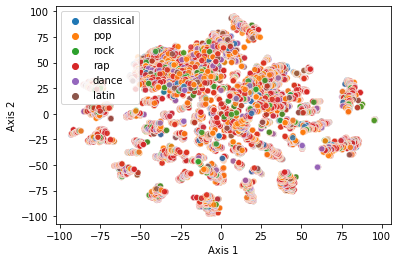

<Figure size 1440x1440 with 0 Axes>

In [63]:
visualize(graph, embeddings, y,id_to_number,labeled = True)

Macro test F1: 0.12711765342876633
Accuracy: 0.13291500285225327
Accuracy of just predicting majority class: 0.0005704506560182544


/opt/anaconda3/envs/torchgeometric/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.12711765342876633

<Figure size 432x288 with 0 Axes>

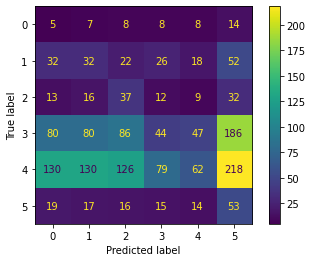

In [160]:
predict(embeddings, y,model = 'lr')

# Traditional ML

In [170]:
X_train.drop('name_x', inplace = True, axis = 1)
X_test.drop('name_x', inplace = True, axis = 1)

In [180]:
degrees = pd.Series(ntx.degree_centrality(G))

In [183]:
degrees.name = "Degree_Centrality"

In [190]:
degrees.loc["7zX44fpv6srJt3HfBv0GCn"]

0.00020128824476650564

In [187]:
X_train.merge(degrees, how = 'left',left_index = True, right_index = True)

,followers_x,artist_popularity_x,num_genres,avg_track_popularity,avg_duration_ms,avg_explicit,avg_danceability,avg_energy,avg_key,avg_loudness,avg_mode,avg_speechiness,avg_acousticness,avg_instrumentalness,avg_liveness,avg_valence,avg_tempo,avg_time_signature,Degree_Centrality
artist_id,,,,,,,,,,,,,,,,,,,
0X7S9BiCFjGRK3U6lazy2J,1820.0,35,1.0,28.666667,234588.222222,0.111111,0.834667,0.612556,4.333333,-6.695444,0.333333,0.309000,0.376111,0.000054,0.173244,0.718889,114.609778,4.000000,0.000115
63iLDTZb43E6k8Ign6voma,127161.0,56,3.0,56.750000,176106.250000,0.750000,0.688750,0.697500,6.500000,-6.601500,0.500000,0.151600,0.157300,0.000001,0.225250,0.440250,111.275000,4.000000,0.000144
699OTQXzgjhIYAHMy9RyPD,4576430.0,84,3.0,68.526316,180543.210526,0.947368,0.724895,0.660684,5.368421,-5.969632,0.421053,0.183295,0.132168,0.000008,0.252900,0.435316,136.919737,4.000000,0.000288
3lwRbCTt1qmo0QgXUai8ao,148920.0,52,3.0,35.000000,214480.000000,0.047619,0.488524,0.511286,6.476190,-9.689476,0.333333,0.047933,0.513190,0.000002,0.242210,0.448319,120.546619,3.952381,0.000058
7zX44fpv6srJt3HfBv0GCn,13696.0,46,3.0,37.500000,223124.900000,0.000000,0.678600,0.706600,5.900000,-5.629300,0.700000,0.081530,0.102418,0.000372,0.177100,0.495500,114.137600,4.000000,0.000201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1itXAnp2giHFQSzcvdN7xg,45114.0,42,2.0,24.341463,245793.317073,0.658537,0.711366,0.689073,6.463415,-6.536268,0.487805,0.263395,0.379895,0.002023,0.175890,0.592732,103.622976,3.951220,0.000173
3vV4Tf1iC8vEP9fLOLGUfP,258623.0,57,4.0,57.333333,248089.333333,0.666667,0.717333,0.703000,4.666667,-6.117667,0.333333,0.189667,0.109433,0.000053,0.165600,0.802000,128.377000,4.000000,0.000029
2KpK4apOMD6evPHoPggSVF,27744.0,57,2.0,50.000000,173486.000000,1.000000,0.718000,0.848000,1.000000,-6.564000,1.000000,0.218000,0.107000,0.000001,0.089900,0.885000,178.046000,4.000000,0.000058


Macro test F1: 0.6960983266776241
Accuracy: 0.7558006846709776


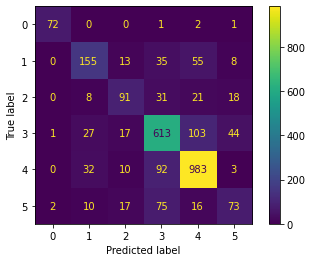

In [191]:
sample_weights = compute_sample_weight('balanced', y_train)
model = XGBClassifier(max_depth=10)
model.fit(X_train, y_train, sample_weight=sample_weights)

y_pred = model.predict(X_test)

    # Evaluate predictions

macro_f1 = f1_score(y_test, y_pred, average = 'macro')
print(f'Macro test F1: {macro_f1}')
accuracy = sum(y_test==y_pred)/len(y_pred)
print(f'Accuracy: {accuracy}')
#print(f'Accuracy of just predicting majority class: {accuracy_majority}')
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

#### Drawing the graph

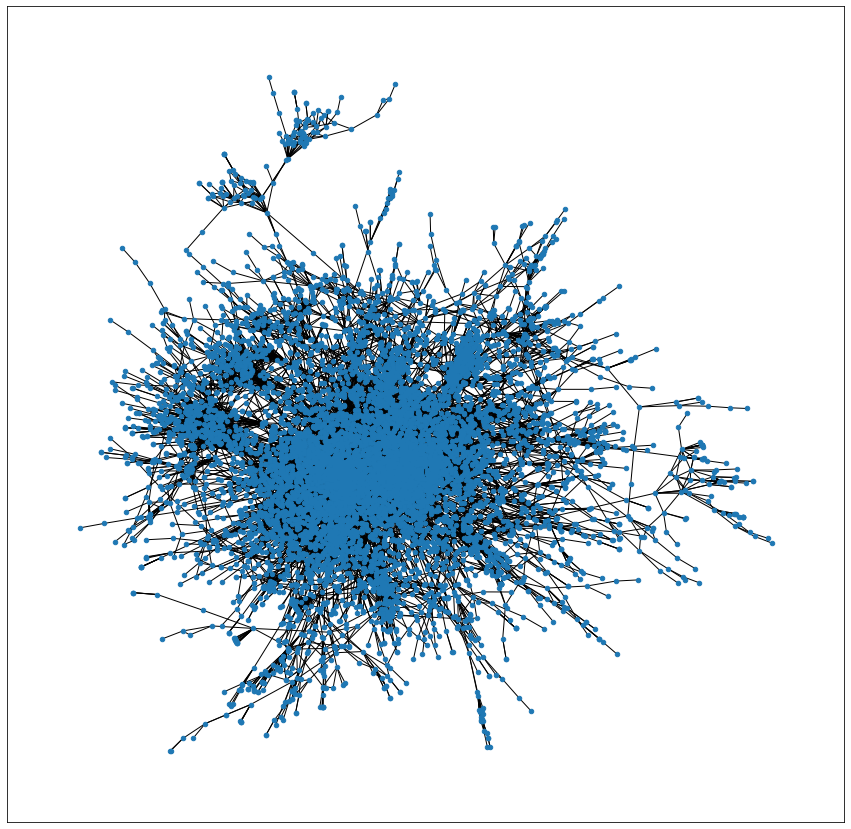

In [12]:
draw_graph(graph)